<a href="https://colab.research.google.com/github/Kryptera-K/AMD-Multi-Oscillator-Cloud-Breakdown-Model/blob/main/AMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AMD"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AMD_clean.csv", index=False)
df

/tmp/ipython-input-506029569.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,15.500000,15.593750,14.687500,14.968750,7843200
2000-01-04,14.625000,15.500000,14.593750,15.125000,6290200
2000-01-05,15.000000,15.062500,14.000000,14.531250,8204600
2000-01-06,16.000000,16.000000,15.250000,15.500000,11489400
2000-01-07,16.250000,16.406250,15.375000,15.406250,8543400
...,...,...,...,...,...
2025-10-27,259.670013,260.420013,249.800003,257.880005,65613100
2025-10-28,258.010010,264.579987,257.000000,259.140015,47448700
2025-10-29,264.329987,267.079987,257.399994,264.190002,49335600


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10
WR_LEVEL = -50
WR_PERIOD = 14

# -------------------------
# Indicator Functions
# -------------------------

def kumo_breakout_bearish(df):
    df = calculate_ichimoku(df)
    return df['Close'] < df[['senkou_span_a', 'senkou_span_b']].min(axis=1)


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def laguerre_rsi_cross_below_level(df, level=LRSI_LEVEL, gamma=LRSI_GAMMA):
    df = df.copy()
    df['LRsi'] = calculate_laguerre_rsi(df['Close'], gamma)
    return (df['LRsi'] < level) & (df['LRsi'].shift(1) >= level)


def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    """
    Calculate Laguerre RSI for a pandas Series of close prices.
    Returns a pandas Series of Laguerre RSI values.
    """
    L0 = L1 = L2 = L3 = 0
    lrsi = []

    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3

        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)

        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)

    return pd.Series(lrsi, index=series.index)


def wr_is_falling(df):
    df = calculate_williams_r(df)
    return df['Williams_%R'].diff() < 0


def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df


def rsi_lower_than_os(df, level=RSI_OVERSOLD_LEVEL):
    df = calculate_rsi(df)
    return df['RSI'] < level


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Ichimoku_Kumo_Breakout_Bearish"] = kumo_breakout_bearish(df)
df["LRsi_Cross_Below_Level"] = laguerre_rsi_cross_below_level(df)

# -------------------------
# Exit conditions
# -------------------------

df["WR_is_Falling"] = wr_is_falling(df)
df["RSI_Lower_Than_OS"] = rsi_lower_than_os(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Ichimoku_Kumo_Breakout_Bearish',
    'LRsi_Cross_Below_Level',
]
exit_conditions = [
    'WR_is_Falling',
    'RSI_Lower_Than_OS',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-10-31 00:00:00
Period                                6498 days 00:00:00
Start Value                                     100000.0
End Value                                 2746315.025641
Total Return [%]                             2646.315026
Benchmark Return [%]                         1632.977027
Max Gross Exposure [%]                             100.0
Total Fees Paid                            102838.021808
Max Drawdown [%]                               86.085365
Max Drawdown Duration                 3031 days 00:00:00
Total Trades                                          91
Total Closed Trades                                   91
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   30.769231
Best Trade [%]                                 203.76886
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-10-31 00:00:00
Period                         6498 days 00:00:00
Start Value                              100000.0
End Value                          1732977.027336
Total Return [%]                      1632.977027
Benchmark Return [%]                  1632.977027
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        96.553191
Max Drawdown Duration          4912 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     1632977.027336
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-1738404457.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


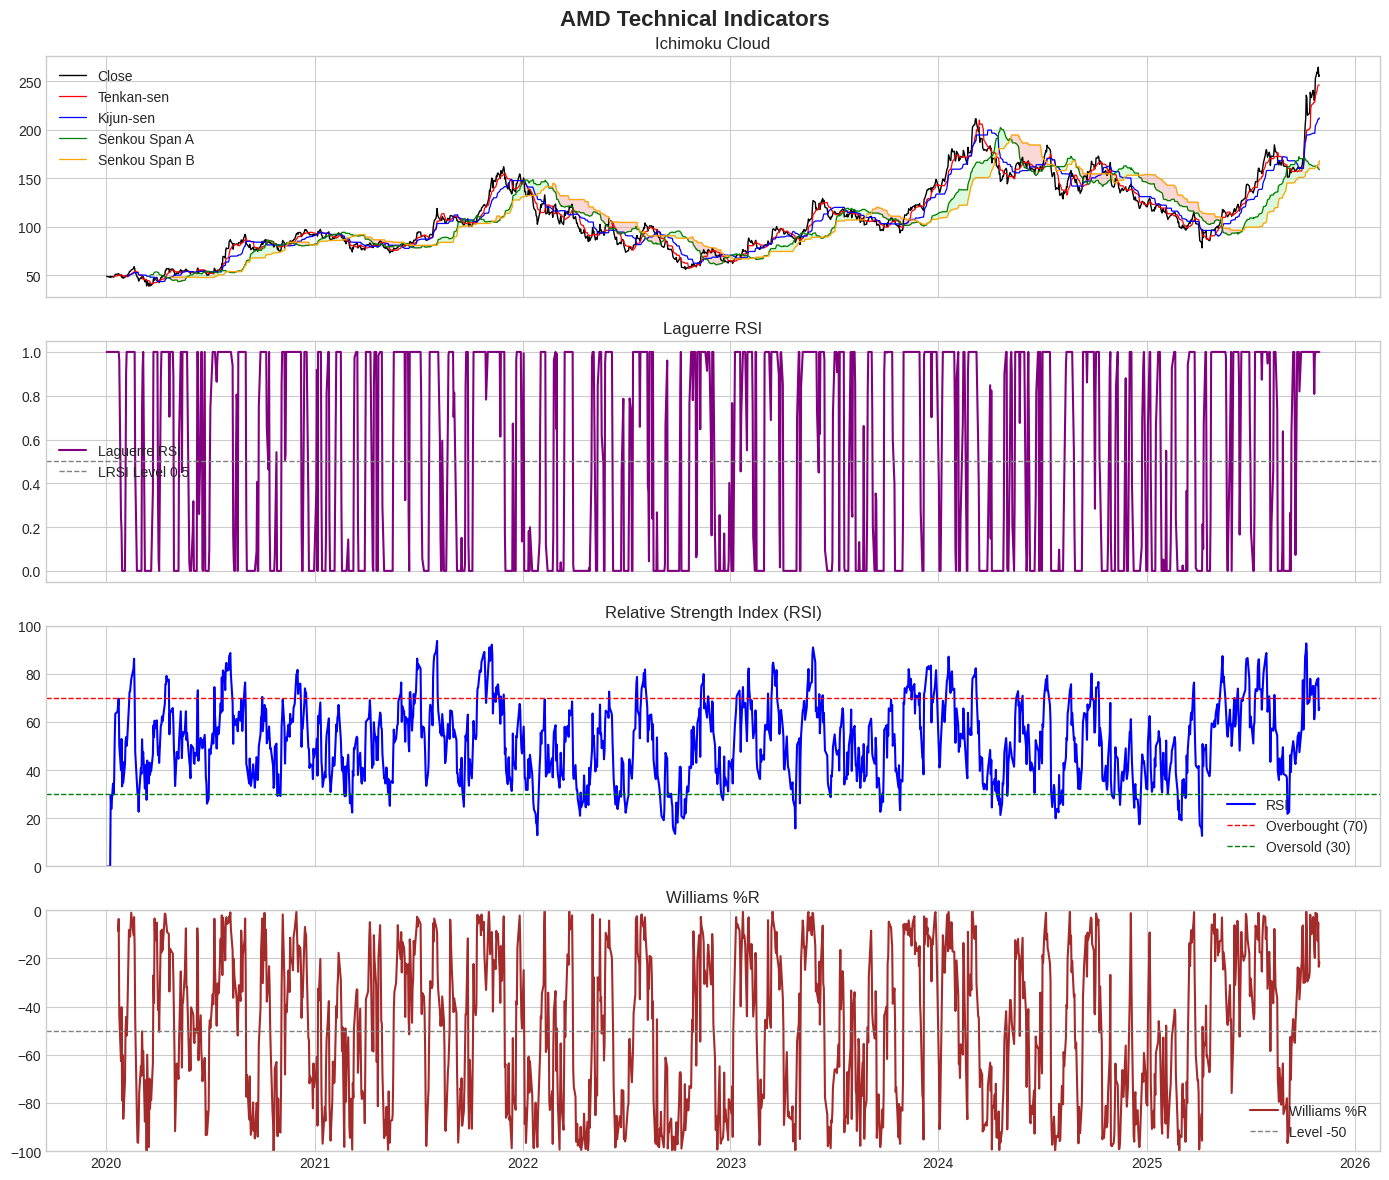

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "AMD"
start_date = "2020-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)

# -------------------------
# Parameters
# -------------------------
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
LRSI_GAMMA = 0.5
LRSI_LEVEL = 0.5
RSI_PERIOD = 14
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
WR_PERIOD = 14
WR_LEVEL = -50

# -------------------------
# Indicator Calculations
# -------------------------
def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD,
                       senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)
    return df

def calculate_laguerre_rsi(series, gamma=LRSI_GAMMA):
    L0 = L1 = L2 = L3 = 0
    lrsi = []
    for price in series:
        L0 = (1 - gamma) * price + gamma * L0
        L1 = -gamma * L0 + L0 + gamma * L1
        L2 = -gamma * L1 + L1 + gamma * L2
        L3 = -gamma * L2 + L2 + gamma * L3
        CU = max(L0 - L1, 0) + max(L1 - L2, 0) + max(L2 - L3, 0)
        CD = max(L1 - L0, 0) + max(L2 - L1, 0) + max(L3 - L2, 0)
        lrsi.append(CU / (CU + CD) if (CU + CD) != 0 else 0)
    return pd.Series(lrsi, index=series.index)

def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

def calculate_williams_r(df, period=WR_PERIOD):
    highest_high = df['High'].rolling(window=period).max()
    lowest_low = df['Low'].rolling(window=period).min()
    df['Williams_%R'] = -100 * (highest_high - df['Close']) / (highest_high - lowest_low)
    return df

# -------------------------
# Apply Indicators
# -------------------------
df = calculate_ichimoku(df)
df['LRsi'] = calculate_laguerre_rsi(df['Close'])
df = calculate_rsi(df)
df = calculate_williams_r(df)

# -------------------------
# Plot All Indicators
# -------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f"{symbol} Technical Indicators", fontsize=16, weight='bold')

# --- 1. Price + Ichimoku Cloud ---
axes[0].plot(df.index, df['Close'], label='Close', color='black', linewidth=1)
axes[0].plot(df.index, df['tenkan_sen'], label='Tenkan-sen', color='red', linewidth=0.9)
axes[0].plot(df.index, df['kijun_sen'], label='Kijun-sen', color='blue', linewidth=0.9)
axes[0].plot(df.index, df['senkou_span_a'], label='Senkou Span A', color='green', linewidth=0.9)
axes[0].plot(df.index, df['senkou_span_b'], label='Senkou Span B', color='orange', linewidth=0.9)
axes[0].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=df['senkou_span_a'] >= df['senkou_span_b'],
                     color='lightgreen', alpha=0.3)
axes[0].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'], where=df['senkou_span_a'] < df['senkou_span_b'],
                     color='lightcoral', alpha=0.3)
axes[0].set_title("Ichimoku Cloud")
axes[0].legend()

# --- 2. Laguerre RSI ---
axes[1].plot(df.index, df['LRsi'], label='Laguerre RSI', color='purple')
axes[1].axhline(LRSI_LEVEL, color='gray', linestyle='--', linewidth=1, label=f'LRSI Level {LRSI_LEVEL}')
axes[1].set_title("Laguerre RSI")
axes[1].legend()

# --- 3. RSI ---
axes[2].plot(df.index, df['RSI'], label='RSI', color='blue')
axes[2].axhline(RSI_OVERBOUGHT_LEVEL, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
axes[2].axhline(RSI_OVERSOLD_LEVEL, color='green', linestyle='--', linewidth=1, label='Oversold (30)')
axes[2].set_ylim(0, 100)
axes[2].set_title("Relative Strength Index (RSI)")
axes[2].legend()

# --- 4. Williams %R ---
axes[3].plot(df.index, df['Williams_%R'], label="Williams %R", color='brown')
axes[3].axhline(WR_LEVEL, color='gray', linestyle='--', linewidth=1, label=f"Level {WR_LEVEL}")
axes[3].set_ylim(-100, 0)
axes[3].set_title("Williams %R")
axes[3].legend()

plt.tight_layout()
plt.show()
